## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


Aplicando transformación

In [5]:
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [6]:
class LogMinimax:
    """
    Transformacion LogMinimax
    """

    @classmethod
    def create(cls, values):

        clase = cls()

        clase.values = values
        clase.log_values = np.log(clase.values)
        clase.max = clase.log_values.max()
        clase.min = clase.log_values.min()

        return clase

    def transformacion(self):

        return (self.log_values - self.min)/(self.max - self.min)

    def inversa(self,y):

        return  np.exp( ( y*(self.max - self.min) ) + self.min )

In [8]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

# Transformacion
#transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )
transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )


data_model['sst'] = transformacion.transformacion()
data_model['sst_exogena'] = transformacion.transformacion()

data_model.head()

,nino34_mean,sst,sst_exogena
periodo,,,
2022-06-01,26.96,0.549133,0.549133
2022-05-01,26.82,0.522145,0.522145
2022-04-01,26.71,0.500842,0.500842
2022-03-01,26.32,0.424597,0.424597
2022-02-01,25.87,0.335206,0.335206


Definiendo datos

In [9]:
y_output = 'sst'
exogena = ['sst_exogena']


pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,sst,sst_exogena
periodo,,
1950-01-01,0.065844,0.065844
1950-02-01,0.172380,0.172380
1950-03-01,0.337210,0.337210
1950-04-01,0.418685,0.418685
1950-05-01,0.398931,0.398931
1950-06-01,0.454055,0.454055
1950-07-01,0.416713,0.416713
1950-08-01,0.337210,0.337210
1950-09-01,0.307078,0.307078


# Entrenamiento RED NARX

Definiendo clase NARX

In [33]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tensorflow import keras
import pygad
import pygad.kerasga

#--------------------------
# KERAS_NARX_NINO34
#--------------------------

class KERAS_NARX_NINO34:

    """
    Clase para el entrenamiento de modelos Keras
    """

    #--
    def __init__(self,pd_model, y_output, exogena, prediction_order, auto_order, exog_order, exog_delay):
        self.pd_model = pd_model[ [y_output] + exogena].sort_index(ascending=True)
        self.y_output = y_output
        self.exogena = exogena
        self.prediction_order = prediction_order
        self.auto_order = auto_order
        self.exog_order = exog_order
        self.exog_delay = exog_delay


    #--
    def split_data(self):
        """
        Funcion para determinar la data de entrenamiento
        """

        self.data_test = self.pd_model[:-self.prediction_order]
        self.input_data, self.output_data = self.date_window(pd_model = self.data_test,
                                        auto_order = self.auto_order,
                                        exog_order = self.exog_order,
                                        exog_delay = self.exog_delay,
                                        exogena = self.exogena,
                                        output = self.y_output)

        # Neuronas capa entrada
        _ , self.ninp = self.input_data.shape


    #--
    def loss_plot(self,title,path):
        """
        Funcion para la visualizacion de la perdida
        """

        self.visualizar_perdida(history=self.history, title=title, path=path)

    #--
    def validation_test(self,model,batch_size):

        """
        Funcion para estudiar resultados
        """

        self.batch_size = batch_size
        self.model = model

        # Prediccion para entrenamiento
        prediction_test = self.model.predict(self.input_data,
                                        batch_size=self.batch_size,
                                        verbose=0,
                                        steps=None,
                                        callbacks=None,
                                        max_queue_size=10,
                                        workers=1,
                                        use_multiprocessing=False)

        # Guardando predicciones
        self.pd_validation = self.pd_model.copy().reset_index(drop=False)
        self.pd_validation['prediction'] = np.nan
        self.pd_validation['type'] = 'training'
        self.pd_validation.loc[ self.data_test.shape[0]: , 'type' ] = 'validation'

        # Prediccion training
        self.pd_validation.loc[ range(max(self.auto_order, self.exog_order),(self.data_test.shape[0])), 'prediction' ] = prediction_test

        # Generando auto predicion
        pd_selfPrediction = self.data_test.copy()
        pd_selfPrediction['type'] = 'historical'

        for x in range(self.prediction_order):
            selfPrediction = self.forecast_one_step( data=pd_selfPrediction.copy(),
                                                model=self.model,
                                                auto_order=self.auto_order,
                                                exog_order=self.exog_order,
                                                exog_delay=self.exog_delay,
                                                exogena=self.exogena,
                                                y_output=self.y_output,
                                                batch_size=self.batch_size)

            selfPrediction[self.exogena] = selfPrediction[self.y_output]

            pd_selfPrediction = pd.concat([pd_selfPrediction, selfPrediction]).copy()  

        self.pd_validation.loc[ self.data_test.shape[0]: , 'prediction' ] = pd_selfPrediction[-self.prediction_order:][self.y_output].to_numpy()

        # Self prediction 
        pd_selfPrediction = self.pd_model.copy()
        for x in range(self.prediction_order):
            selfPrediction = self.forecast_one_step( data=pd_selfPrediction.copy(),
                                                model=self.model,
                                                auto_order=self.auto_order,
                                                exog_order=self.exog_order,
                                                exog_delay=self.exog_delay,
                                                exogena=self.exogena,
                                                y_output=self.y_output,
                                                batch_size=self.batch_size)

            selfPrediction[self.exogena] = selfPrediction[self.y_output]
            pd_selfPrediction = pd.concat([pd_selfPrediction, selfPrediction]).copy()  


        pd_forecast = pd_selfPrediction[-self.prediction_order:][[self.y_output]+['type']].reset_index()
        pd_forecast['prediction'] = pd_forecast[self.y_output]
        pd_forecast[self.y_output] = np.nan
        pd_forecast[self.exogena] = np.nan

        self.pd_validation = pd.concat([self.pd_validation, pd_forecast[self.pd_validation.columns]])



    #--
    @staticmethod
    def forecast_one_step(data,model,auto_order,exog_order,exog_delay,exogena,y_output,batch_size):
        """
        Funcion para la prediccion a one step
        """

        # Pandas Data Frame
        pd_update = pd.DataFrame()
        # Agregando Index 
        pd_update['periodo'] = pd.to_datetime([ (data.index.max() + pd.DateOffset(months=1) ).strftime('%Y-%m')])
        pd_update = pd_update.set_index('periodo')
        #print(pd_update.index )
        pd_update[y_output] = np.nan
        for col in exogena:
            pd_update[col] = np.nan

        pd_update['type'] = 'self_prediction'

        # Formato a los datos
        input_data_validate, _ = KERAS_NARX_NINO34.date_window(pd_model=data.copy(),
                                                                auto_order=auto_order,
                                                                exog_order=exog_order,
                                                                exog_delay=exog_delay,
                                                                exogena=exogena,
                                                                output=y_output)

        # Data para pronostico
        past_row = input_data_validate[-1].reshape(1, input_data_validate.shape[1])

        # prediccion
        prediction_validation = model.predict(  past_row,
                                                batch_size=batch_size,
                                                verbose=0,
                                                steps=None,
                                                callbacks=None,
                                                max_queue_size=10,
                                                workers=1,
                                                use_multiprocessing=False)

        pd_update[y_output] = prediction_validation.flat[0]

        return pd_update

    #--
    @staticmethod
    def date_window(pd_model,auto_order,exog_order,exog_delay,exogena,output):
        """
        Funcion para estructurar los datos de entrada del modelo NARX
        """

        X = pd_model[exogena].to_numpy().astype(float)
        y = pd_model[[output]].to_numpy().astype(float)

        # Data para el mmodelo
        input_data = []
        output_data = []
        for t in range(max(auto_order, exog_order), len(y)):
            input_data.append(np.concatenate((y[(t - auto_order + 1):(t + 1)], X[(t - exog_delay - exog_order + 1):(t - exog_delay + 1)]), axis=0) )
            output_data.append(np.array(y[t]))

        # Input del modelo
        input_data = np.array(input_data)
        # Output del modelo
        output_data = np.array(output_data)

        return (input_data.reshape(input_data.shape[0],input_data.shape[1]), output_data)

    #--
    @staticmethod
    def visualizar_perdida(history, title, path):
        """
        Funcion para visualizar la funcion de perdida de la red NARX
        """
        params = {'legend.fontsize': 'x-large',
                #'figure.figsize': (15, 10),
                'axes.labelsize': 'x-large',
                'axes.titlesize':'x-large',
                'xtick.labelsize':'x-large',
                'ytick.labelsize':'x-large'}

        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(len(loss))
        plt.figure(figsize=(15,10))
        pylab.rcParams.update(params)
        plt.plot(epochs, loss, "b", label="Entrenamiento")
        plt.plot(epochs, val_loss, "r", label="Validación")
        
        plt.title('Pérdida en el entrenamiento y validación',loc='left',fontsize=18)
        plt.suptitle(title,ha='left',fontsize=30,x=0.12)
        plt.xlabel("Épocas",fontsize=18)
        plt.ylabel("Pérdida",fontsize=18)
        plt.legend()

        plt.savefig(path)

        plt.show()



    #--
    @staticmethod
    def metrics(hidden_layer_sizes,observado,prediccion):

        """
        Calculo de las metricas del modelo
        """
        
        from sklearn.metrics import (mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score)

        return {'hidden_layer_sizes': hidden_layer_sizes,
              'map':[mean_absolute_percentage_error(observado, prediccion)],
              'mae':[mean_absolute_error(observado, prediccion)],
              'rmse':[mean_squared_error(observado, prediccion,squared=False)],
              'r2': [r2_score(observado, prediccion, multioutput='variance_weighted')],
              }


    #--
    @staticmethod
    def graf(data_figure_ajuste,data_figure_validacion,data_figure_pronostico,y,y_predict):
        
        import plotly.graph_objects as go
        from plotly.graph_objects import Layout

        fig = go.Figure(layout=Layout(plot_bgcolor='rgba(0,0,0,0)'))

        fig.add_annotation(x=data_figure_ajuste.index.max() - pd.DateOffset(months=3*12),#pd.Timestamp('2019-01-01'),
                    y=29,
                    text="Entrenamiento",
                    showarrow=False,
                    yshift=10)

        fig.add_trace(go.Scatter(x=data_figure_ajuste.index, y=data_figure_ajuste[y_predict],
                                mode='lines+markers',name='Pronóstico entrenamiento',
                                marker_symbol='x-thin',
                                marker_line_width=3,
                                marker_size=3,
                                marker_line_color='#000000',
                                marker_color='#000000',
                                line=dict(color='#FF7203', width=2)))

        fig.add_trace(go.Scatter(x=data_figure_ajuste.index, y=data_figure_ajuste[y],
                                mode='lines+markers',name='SST entrenamiento',
                                marker_symbol='x-thin',
                                marker_line_width=3,
                                marker_size=3,
                                marker_line_color='#000000',
                                marker_color='#000000',
                                line=dict(color='#C10101', width=2)))


        months = int(data_figure_pronostico.shape[0]/3)
        fig.add_annotation(x= data_figure_validacion.index.min() + pd.DateOffset(months=months)  ,#pd.Timestamp('2021-07-01'),
                    y=29,
                    text="Validación",
                    showarrow=False,
                    yshift=10)
        fig.add_trace(go.Scatter(x=data_figure_validacion.index, y=data_figure_validacion[y_predict],
                            mode='lines+markers',name='Pronóstico validación',                       
                                marker_symbol='square',
                                marker_line_width=2,
                                marker_size=3,
                                marker_line_color='#030BFF',
                                marker_color='#030BFF', 
                                line=dict(color='#FF7203', width=2)
                                ))

        fig.add_trace(go.Scatter(x=data_figure_validacion.index, y=data_figure_validacion[y],
                            mode='lines+markers',name='SST validación',
                            marker_symbol='square',
                            marker_line_width=2,
                            marker_size=3,
                            marker_line_color='#030BFF',
                            marker_color='#030BFF', 
                            line=dict(color='#C10101', width=2)))



        fig.add_annotation(x=data_figure_pronostico.index.min() + pd.DateOffset(months=months),#pd.Timestamp('2022-09-01'),
                    y=29,
                    text="Pronóstico",
                    showarrow=False,
                    yshift=10)
        fig.add_trace(go.Scatter(x=data_figure_pronostico.index, y=data_figure_pronostico[y_predict],
                                text=data_figure_pronostico[y_predict].apply(lambda x: str(round(x,2)) ),
                                textposition="top right",
                                marker_symbol='star',
                                marker_line_width=3,
                                marker_size=3,
                                marker_line_color='#EA9800',
                                marker_color='#EA9800',
                                mode='lines+markers+text',name='Pronóstico SST',
                                line=dict(color='#FF7203', width=2,dash='dash')))

        fig.add_vline(x=data_figure_ajuste.index.max(), line_width=3, line_dash="dash", line_color="#580606")
        fig.add_vline(x=data_figure_validacion.index.max(), line_width=3, line_dash="dash", line_color="#580606")


        fig.update_xaxes(tickformat="%Y/%m",showline=True, linewidth=1, linecolor='black', gridcolor='#E4E4E4',mirror=True,
                        ticks="outside", tickwidth=2, tickcolor='#5C2B05', ticklen=10)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', gridcolor='#E4E4E4',mirror=True,
                        ticks="outside", tickwidth=2, tickcolor='#5C2B05', ticklen=10)


        fig.update_traces(textfont_size=11)
        fig.update_layout(title="""
                            SST promedio en la región NIÑO 3.4 
                            <br><sup>Pronóstico para el periodo {date_init} al {date_fin}</sup>
                            """.format(date_init=str(data_figure_pronostico.index.min().strftime('%Y-%m-%d')),
                                    date_fin=str(data_figure_pronostico.index.max().strftime('%Y-%m-%d')) ),
                        xaxis_title='Mes',
                        yaxis_title='Temperatura (°C)',
                        legend_title_text='Serie',
                        legend_title = dict( font = dict(size = 25)),
                        legend=dict(y=0.5,
                                    #traceorder='reversed',
                                    font_size=22),
                        uniformtext_minsize=8,
                        uniformtext_mode='hide',
                        height=800,
                        width=1500,
                        font = dict(size = 22),
                        xaxis_range=[ data_figure_ajuste.index.max() - pd.DateOffset(months=5*12) , data_figure_pronostico.index.max()+pd.DateOffset(months=3)  ],

                        )

        return fig

Definiendo parámetros iniciales

In [11]:
prediction_order = 12 # rango de prediccion
auto_order = 30*12 # componente autoregresiva
exog_order = 12 # componente exogena qm
exog_delay = 0# componente exogena dm


training_model = KERAS_NARX_NINO34(pd_model = pd_model,
                                    y_output = y_output,
                                    exogena = exogena,
                                    prediction_order = prediction_order,
                                    auto_order = auto_order,
                                    exog_order = exog_order,
                                    exog_delay = exog_delay)

# Generando datos para entrenamiento 
training_model.split_data()

In [12]:
training_model.input_data.shape

(498, 372)

Definición de modelo Multilayer Perceptron

In [3]:
#--------------------------
# MyLRSchedule
#--------------------------

class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning rate 
    """

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
       return self.initial_learning_rate / (step + 1)


#--------------------------
# MultilayerPerceptron
#--------------------------

class MultilayerPerceptron:

    def __init__(self,ninp,
                    n_neurons,
                    activation,
                    kernel_initializer,
                    bias_initializer,
                    nout = 1,
                    confi = {'Input':{'batch_size':None,
                                    'name':'input',
                                    'dtype':None,
                                    'sparse':None,
                                    'tensor':None,
                                    'ragged':None,
                                    'type_spec':None},
                            'Dense':{'use_bias':True,
                                    'kernel_regularizer':None,
                                    'bias_regularizer':None,
                                    'activity_regularizer':None,
                                    'kernel_constraint':None,
                                    'bias_constraint':None
                                    }
                            }

                    ):

        import os
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


        # Asignando valores
        self.ninp = ninp
        self.n_neurons = n_neurons 
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.nout = nout
        self.confi = confi
        self.base_model = MultilayerPerceptron.create_model(ninp=self.ninp,
                                                            n_neurons=self.n_neurons,
                                                            activation=self.activation,
                                                            kernel_initializer=self.kernel_initializer,
                                                            bias_initializer=self.bias_initializer,
                                                            nout=self.nout,
                                                            confi=self.confi)
        self.layer_in = self.base_model.get('layer_in')
        self.dense_layer = self.base_model.get('dense_layer')
        self.layer_output = self.base_model.get('layer_output')
        self.model = self.base_model.get('model')

    #--
    @staticmethod
    def create_model(ninp, n_neurons, activation, kernel_initializer, bias_initializer, nout, confi):

        # Entrada
        layer_in = keras.layers.Input(shape=(ninp,),
                                    batch_size = confi.get('Input').get('batch_size'),
                                    name = confi.get('Input').get('name'),
                                    dtype = confi.get('Input').get('dtype'),
                                    sparse = confi.get('Input').get('sparse'),
                                    tensor = confi.get('Input').get('tensor'),
                                    ragged = confi.get('Input').get('ragged'),
                                    type_spec = confi.get('Input').get('type_spec')
                                    )

        # Hidden Leyers
        dense_layer = keras.layers.Dense( units=n_neurons[0],
                                        activation=activation[0],
                                        use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=kernel_initializer[0],
                                        bias_initializer=bias_initializer[0],
                                        kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(layer_in)

        if len(n_neurons) > 1:
            for x in zip(n_neurons[1:], activation[1:], kernel_initializer[1:], bias_initializer[1:]):
                dense_layer = keras.layers.Dense( units=x[0],
                                        activation=x[1],
                                        use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=x[2],
                                        bias_initializer=x[3],
                                        kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(dense_layer)

        # Out
        layer_output = keras.layers.Dense(units=nout,
                                        activation='linear',
                                        # use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=kernel_initializer[-1],
                                        bias_initializer=bias_initializer[-1],
                                        # kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        # bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        # activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        # kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        # bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(dense_layer)

        # Definiendo modelo
        model = keras.models.Model(inputs=[layer_in],outputs=[layer_output])

        return {'layer_in':layer_in,
                'dense_layer':dense_layer,
                'layer_output':layer_output,
                'model':model
                }

Definiendo modelo

In [14]:
# Definmiendo Modelo
ninp = training_model.ninp
n_neurons = [ninp]
activation = ['tanh']
kernel_initializer = ['lecun_normal']
bias_initializer = ['zeros']

data_inputs = training_model.input_data
data_outputs = training_model.output_data
model = MultilayerPerceptron(ninp=ninp,
                            n_neurons=n_neurons,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer).model

In [36]:
# Learning rate
# learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
#                                                             decay_steps=10000,
#                                                             decay_rate=0.9)

# learning_rate = MyLRSchedule(1e-3)

learning_rate = 1e-3

# Optimizador
optimizer = keras.optimizers.Adam(learning_rate=learning_rate,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,
                                amsgrad=False,
                                name="Adam"
                                )


# optimizer = keras.optimizers.SGD(learning_rate=learning_rate,
#                                 momentum=0.0,
#                                 nesterov=False,
#                                 name="SGD"
#                                 )

# Perdida
loss = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")


# Metrícas
def coeff_determination(y_true, y_pred):
    from keras import backend as K

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )

    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

map = keras.metrics.MeanAbsolutePercentageError()
#mae = keras.metrics.mean_absolute_error()
rmse = keras.metrics.RootMeanSquaredError()

# Compilando el modelo a entrenar
model.compile( optimizer=optimizer,
                loss=loss,
                metrics=[coeff_determination,map,rmse],
                loss_weights=None,
                weighted_metrics=None,
                run_eagerly=None,
                steps_per_execution=None,
                jit_compile=None)


path_checkpoint = "./model_checkpoint/nino34/narx_sst_nino34.h5"
monitor = 'val_loss'
modelckpt_callback = keras.callbacks\
                            .ModelCheckpoint(filepath = path_checkpoint,
                                            monitor=monitor,
                                            verbose=0,
                                            save_best_only=True,
                                            save_weights_only=True,
                                            mode="auto",
                                            save_freq="epoch",
                                            options=None,
                                            initial_value_threshold=None
                                            )

Datos de entrenamiento de la red

In [37]:
x = training_model.input_data
y = training_model.output_data
validation_split = 0.2

Proceso de entrenamiento de la red NARX

In [38]:
epochs = 1000
max_epochs = 100*epochs
r2_max = 0.4139817371616692

history_list = []
while max_epochs >= epochs:

    try:
        # Cargando pesos
        model.load_weights('./model_checkpoint/nino34/narx_sst_nino34_weights.h5')#(path_checkpoint)
    except:
        print('Pesos cargados')
        pass

    # Entrenamiento
    history = model.fit(x=x,
                        y=y,
                        epochs=500,
                        verbose=0,
                        validation_split=validation_split,
                        callbacks=[modelckpt_callback])

    history_list.append(history)
    if len (history_list)>10:
        history_list = history_list[-10:]

    # Validacion
    training_model.validation_test(model=model, batch_size=x.shape[0])

    # Metricas
    pd_summary = training_model.pd_validation.copy()
    pd_summary.index = pd.to_datetime(pd_summary.periodo)
    pd_summary['nino34_mean'] = pd_summary['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
    pd_summary['prediction_nino34_mean'] = pd_summary['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

    pd_training = pd_summary[pd_summary.type=='training'].dropna()[['nino34_mean','prediction_nino34_mean']]
    training_model.metrics([],pd_training.nino34_mean,pd_training.prediction_nino34_mean)

    pd_validation = pd_summary[pd_summary.type=='validation'][['nino34_mean','prediction_nino34_mean']]
    r2 = training_model.metrics([],pd_validation.nino34_mean,pd_validation.prediction_nino34_mean).get('r2')

    if r2[0] > r2_max:

        r2_max = r2[0]

        # Save Pesos
        model.save_weights('./model_checkpoint/nino34/narx_sst_nino34_weights.h5')
        model.save('./model_checkpoint/nino34/narx_sst_nino34_model.h5')

        # Save History
        import pickle
        with open('./model_checkpoint/nino34/history.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

    if r2_max > 0.5:
        break

    # Asignando valor
    print('epochs',epochs,'r2',r2)
    epochs += 500

epochs 1000 r2 [-6.191907496689611]
epochs 1500 r2 [-2.978351050606026]
epochs 2000 r2 [-10.785117654504752]
epochs 2500 r2 [-9.692426197819014]
epochs 3000 r2 [-10.739056615728739]
epochs 3500 r2 [-13.971311797736048]
epochs 4000 r2 [-17.86253650879069]
epochs 4500 r2 [-15.752205400485702]
epochs 5000 r2 [-0.9332453568317064]
epochs 5500 r2 [-18.786597463291283]
epochs 6000 r2 [-1.6539444334906106]
epochs 6500 r2 [-0.9590431405676054]
epochs 7000 r2 [-17.825514035044193]
epochs 7500 r2 [-3.461522957200577]
epochs 8000 r2 [-1.789267923366318]
epochs 8500 r2 [-16.686320443364536]
INFO:tensorflow:Assets written to: ram://d43cdc40-2ca3-4a67-901a-e23a118ae61e/assets


Guardando la historia del entrenamiento

In [124]:
history = dict(history_list[0].history)

for x in history_list[1:]:
    history = {'loss':history.get('loss') + x.history.get('loss'),
                'coeff_determination':history.get('coeff_determination') + x.history.get('coeff_determination'),
                'mean_absolute_percentage_error':history.get('mean_absolute_percentage_error') + x.history.get('mean_absolute_percentage_error'),
                'root_mean_squared_error':history.get('root_mean_squared_error') + x.history.get('root_mean_squared_error'),
                'val_loss':history.get('val_loss') + x.history.get('val_loss'),
                'val_coeff_determination':history.get('val_coeff_determination') + x.history.get('val_coeff_determination'),
                'val_mean_absolute_percentage_error':history.get('val_mean_absolute_percentage_error') + x.history.get('val_mean_absolute_percentage_error'),
                'val_root_mean_squared_error':history.get('val_root_mean_squared_error') + x.history.get('val_root_mean_squared_error'),
             }

np.save('./model_checkpoint/nino34/narx_sst_nino34_history.npy',history)

In [125]:
history = np.load('./model_checkpoint/nino34/narx_sst_nino34_history.npy',allow_pickle='TRUE').item()
history.keys()

dict_keys(['loss', 'coeff_determination', 'mean_absolute_percentage_error', 'root_mean_squared_error', 'val_loss', 'val_coeff_determination', 'val_mean_absolute_percentage_error', 'val_root_mean_squared_error'])

In [122]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 372)]             0         
                                                                 
 dense (Dense)               (None, 372)               138756    
                                                                 
 dense_1 (Dense)             (None, 1)                 373       
                                                                 
Total params: 139,129
Trainable params: 139,129
Non-trainable params: 0
_________________________________________________________________


# Resultados del entrenamiento de la red

In [87]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
        #'figure.figsize': (15, 10),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}

Función de pérdida

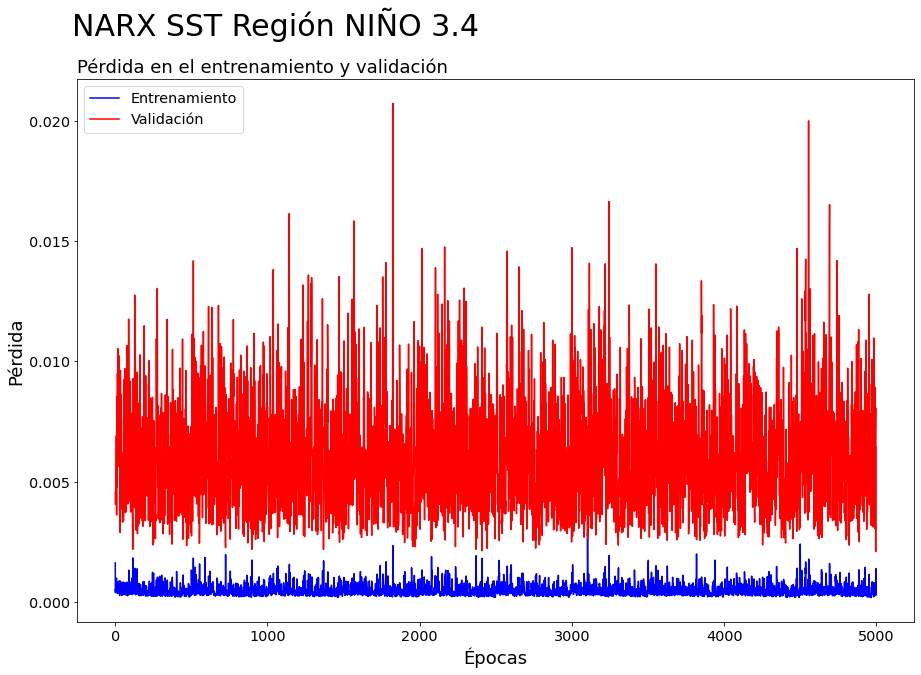

In [88]:
title = 'NARX SST Región NIÑO 3.4'

loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
plt.plot(epochs, loss, "b", label="Entrenamiento")
plt.plot(epochs, val_loss, "r", label="Validación")

plt.title('Pérdida en el entrenamiento y validación',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("Pérdida",fontsize=18)
plt.legend()

plt.savefig('./figure/nino34/loss_narx_model_nino34.png')
plt.show()

Coeficiente de determinación

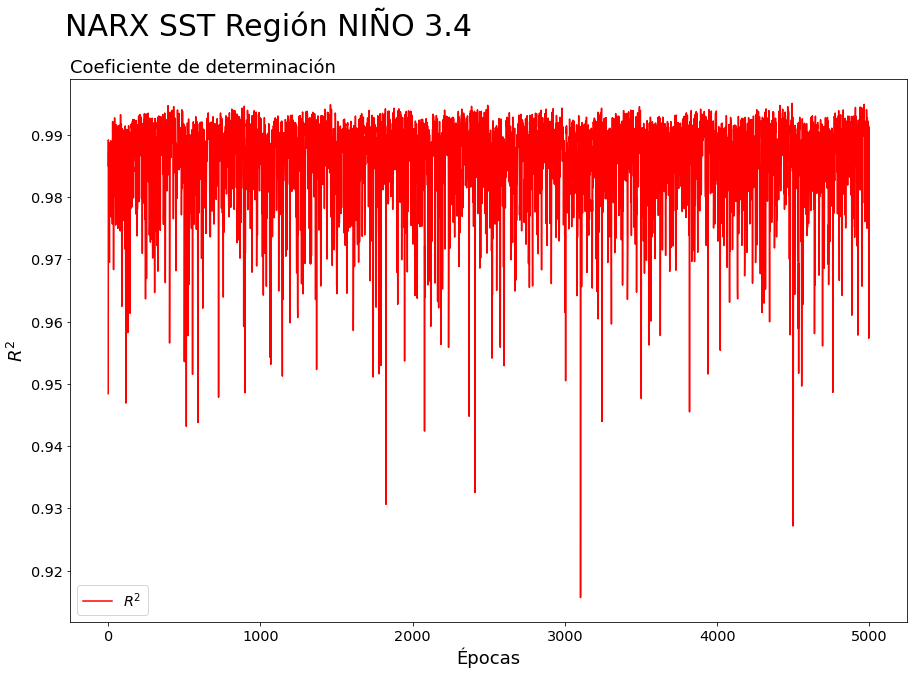

In [100]:
title = 'NARX SST Región NIÑO 3.4'
loss = history["loss"]
val_loss = history["coeff_determination"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
plt.plot(epochs, val_loss, "r", label="$R^2$")

plt.title('Coeficiente de determinación',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("$R^2$",fontsize=18)
plt.legend()

plt.savefig('./figure/nino34/r2_narx_model_nino34.png')
plt.show()

Error porcentual absoluto medio

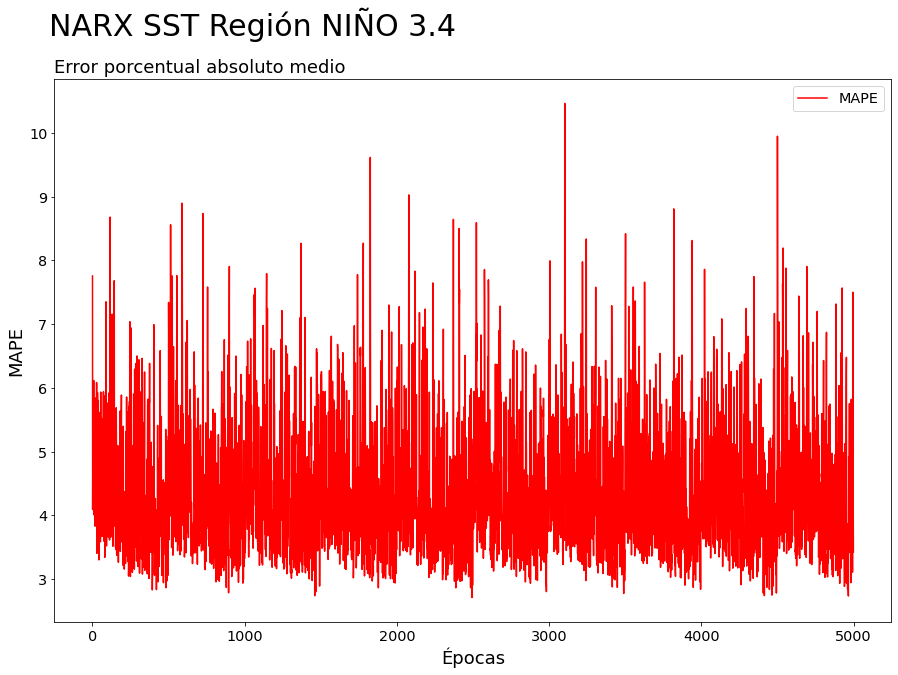

In [106]:
title = 'NARX SST Región NIÑO 3.4'
loss = history["loss"]
val_loss = history["mean_absolute_percentage_error"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
plt.plot(epochs, val_loss, "r", label="MAPE")

plt.title('Error porcentual absoluto medio',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("MAPE",fontsize=18)
plt.legend()

plt.savefig('./figure/nino34/mape_narx_model_nino34.png')
plt.show()

# Validación de la red NARX

In [137]:
# Cargando pesos
model.load_weights('./model_checkpoint/nino34/narx_sst_nino34_weights.h5')

# Validacion
training_model.validation_test(model=model, batch_size=training_model.input_data.shape[0])

# Metricas
pd_summary = training_model.pd_validation.copy()
pd_summary.index = pd.to_datetime(pd_summary.periodo)
pd_summary['nino34_mean'] = pd_summary['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
pd_summary['prediction_nino34_mean'] = pd_summary['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

pd_training = pd_summary[pd_summary.type=='training'].dropna()[['nino34_mean','prediction_nino34_mean']]
training = training_model.metrics([],pd_training.nino34_mean,pd_training.prediction_nino34_mean)
print("--Metricas Entrenamiento")
print(training)

print("--Metricas Validacion")
pd_validation = pd_summary[pd_summary.type=='validation'][['nino34_mean','prediction_nino34_mean']]
validacion = training_model.metrics([],pd_validation.nino34_mean,pd_validation.prediction_nino34_mean)
print(validacion)

--Metricas Entrenamiento
{'hidden_layer_sizes': [], 'map': [0.006320263324837098], 'mae': [0.17118135896545497], 'rmse': [0.23731528605072996], 'r2': [0.942905251924998]}
--Metricas Validacion
{'hidden_layer_sizes': [], 'map': [0.009898945899390313], 'mae': [0.2570616399108501], 'rmse': [0.3107110789348499], 'r2': [0.6147804297643635]}


In [139]:
# respaldo del modelo
import pickle

with open('./respaldonarx_model.pkl', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://96b5b7c0-98fa-4821-9eb9-e67841178a5e/assets


# Pronóstico de la RED NARX

In [ ]:
# Respaldo de la informacion
pd_summary.to_pickle('./data/nino34/forecast_narx_sst_nino34.pkl')

In [5]:
# Respaldo de la informacion
pd_summary = pd.read_pickle('./data/nino34/forecast_narx_sst_nino34.pkl')
pd_summary.head()

,periodo,sst,sst_exogena,prediction,type,nino34_mean,prediction_nino34_mean
periodo,,,,,,,
1950-01-01,1950-01-01,0.065844,0.065844,NaN,training,24.56,NaN
1950-02-01,1950-02-01,0.172380,0.172380,NaN,training,25.07,NaN
1950-03-01,1950-03-01,0.337210,0.337210,NaN,training,25.88,NaN
1950-04-01,1950-04-01,0.418685,0.418685,NaN,training,26.29,NaN
1950-05-01,1950-05-01,0.398931,0.398931,NaN,training,26.19,NaN


In [34]:
fig = KERAS_NARX_NINO34.graf(data_figure_ajuste=pd_summary[pd_summary.type=='training'],
                        data_figure_validacion=pd_summary[pd_summary.type=='validation'],
                        data_figure_pronostico=pd_summary[pd_summary.type=='self_prediction'],
                        y='nino34_mean',
                        y_predict='prediction_nino34_mean')

fig.write_image('./figure/nino34/pronostico_sstt.png')
fig.show()